In [1]:
import math
import os
import time
import numpy as np
import pandas as pd

from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam, SGD
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, InputLayer, Conv1D, MaxPooling1D, Flatten, TimeDistributed, LayerNormalization, Activation, GRU
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from keras._tf_keras.keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


from model.CNN_LSTM.components.engineering import FeatureEngineering
from model.CNN_LSTM.components.dfmodify import DataframeModify 
from model.CNN_LSTM.components.dfcreation import DataframeCreate

In [2]:
def preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', StandardScaler())
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            # ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=-1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list) -> pd.DataFrame:
    df_copy = df.copy()
    _ = FeatureEngineering.calculate_temporal_features(df_copy, landmark_cols)
    df_combined = df_copy.loc[:, ~df_copy.columns.duplicated()] # removed any duplicate columns
    return df_combined

def create_graphs(history_dev_1, cm, class_labels):
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.ion()
    plt.show()

    # Extracting the history
    train_loss = history_dev_1.history['loss']
    val_loss = history_dev_1.history['val_loss']
    train_acc = history_dev_1.history['accuracy']
    val_acc = history_dev_1.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot training and validation loss
    ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plot training and validation accuracy
    ax2.plot(epochs, train_acc, label='Train Accuracy', color='tab:green')
    ax2.plot(epochs, val_acc, label='Validation Accuracy', color='tab:red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    # Adjust layout to prevent overlap
    fig.tight_layout()

    # Display the plots
    plt.show()


In [3]:
input_path = r"C:\Users\Gen3r\Documents\capstone\ml_model\data\data_3"
dataframe = DataframeCreate.create_dataframe_from_data(input_path=input_path)
X_train, y_train, X_val, y_val, X_test, y_test = DataframeCreate.split_dataset(df=dataframe, target_label='gesture')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

landmark_columns = [f"{col}" for col in dataframe.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
categorical_columns = ["gesture_index"]
numerical_columns = ["frame", "frame_rate", "frame_width", "frame_height"] + [f"{col}" for col in dataframe.columns if col.startswith("pose_visibility")]
derived_features =  [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk"] for col in landmark_columns if col.startswith(("lx", "ly", "lz", "rx", "ry", "rz"))]
time_series_columns = landmark_columns + derived_features     
res = [item for item in landmark_columns if item.startswith(("r", "l"))]

# only augment train
X_train_augmented, y_train = DataframeModify.augment_model(X_train, y_train, noise_level=0.05, translation_vector=[0.6, -0.5, 0.05], rotation_angle=45)
X_train_combined = pd.concat([X_train, X_train_augmented], axis=0, ignore_index=True)
X_train_augmented_2, y_train = DataframeModify.augment_model(X_train_combined, y_train, noise_level=0.04, translation_vector=[0.2, 0.65, -0.15], rotation_angle=15)
X_train_combined_2 = pd.concat([X_train_combined, X_train_augmented_2], axis=0, ignore_index=True)
print("finish augmentation")

X_train_transformed = None
X_val_transformed = None
X_test_transformed = None
if os.path.exists("X_train_transformed.csv"):
    X_train_transformed = pd.read_csv("X_train_transformed.csv")
    X_val_transformed = pd.read_csv("X_val_transformed.csv")
    X_test_transformed = pd.read_csv("X_test_transformed.csv")
else:
    # note, features should be applied to both training and other sets, but for feature looking ahead in the data - time series feastures, only apply it to train
    X_train_fe = calculate_hand_motion_features(X_train_combined_2, res)
    X_val_fe = calculate_hand_motion_features(X_val, res)
    X_test_fe = calculate_hand_motion_features(X_test, res)
    print("finish feature engineering")

    preprocessor = preprocess_pipeline(time_series_columns, numerical_columns, categorical_columns)
    X_train_transformed = preprocessor.fit_transform(X_train_fe)
    X_val_transformed = preprocessor.transform(X_val_fe)
    X_test_transformed = preprocessor.transform(X_test_fe)

print(X_train_transformed.shape, y_train.shape, X_val_transformed.shape, y_val.shape, X_test_transformed.shape, y_test.shape)

# Define sequence length
sequence_length = 30  # or whatever is appropriate

# Create sequences for training, validation, and testing
X_train_sequences, y_train_sequences = DataframeModify.create_sequences_with_labels(X_train_transformed, y_train, sequence_length)
X_val_sequences, y_val_sequences = DataframeModify.create_sequences_with_labels(X_val_transformed, y_val, sequence_length)
X_test_sequences, y_test_sequences = DataframeModify.create_sequences_with_labels(X_test_transformed, y_test, sequence_length)

# Print shapes to verify
print(X_train_sequences.shape)
print(X_val_sequences.shape)
print(X_test_sequences.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

class_labels = np.unique(y_test_sequences.tolist())
class_labels

# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sequences)
y_val_encoded = label_encoder.transform(y_val_sequences)
y_test_encoded = label_encoder.transform(y_test_sequences)

y_train_categorical = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_categorical = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))


(16080, 1667) (16080, 1) (3600, 1667) (3600, 1) (3240, 1667) (3240, 1)
finish augmentation
(64320, 2045) (64320, 1) (3600, 2045) (3600, 1) (3240, 2045) (3240, 1)
(2144, 30, 2044)
(120, 30, 2044)
(108, 30, 2044)
(64320, 1)
(3600, 1)
(3240, 1)


In [7]:
# pd.DataFrame.to_csv(X_train_transformed, "X_train_transformed.csv", index=False)
# pd.DataFrame.to_csv(X_val_transformed, "X_val_transformed.csv", index=False)
# pd.DataFrame.to_csv(X_test_transformed, "X_test_transformed.csv", index=False)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.0944 - loss: 4.4592 - val_accuracy: 0.1417 - val_loss: 4.1747 - learning_rate: 1.0000e-04
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.1581 - loss: 4.1438 - val_accuracy: 0.1417 - val_loss: 4.0274 - learning_rate: 1.0000e-04
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.2679 - loss: 3.8486 - val_accuracy: 0.2583 - val_loss: 3.8484 - learning_rate: 1.0000e-04
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.3683 - loss: 3.5405 - val_accuracy: 0.3417 - val_loss: 3.7328 - learning_rate: 1.0000e-04
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.4435 - loss: 3.3448 - val_accuracy: 0.4167 - val_loss: 3.6140 - learning_rate: 1.0000e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.5176 - loss: 3.1314 - val_accuracy: 0.4500 - val_loss: 3.5509 - learning_rate: 1.0000e-04
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - ac

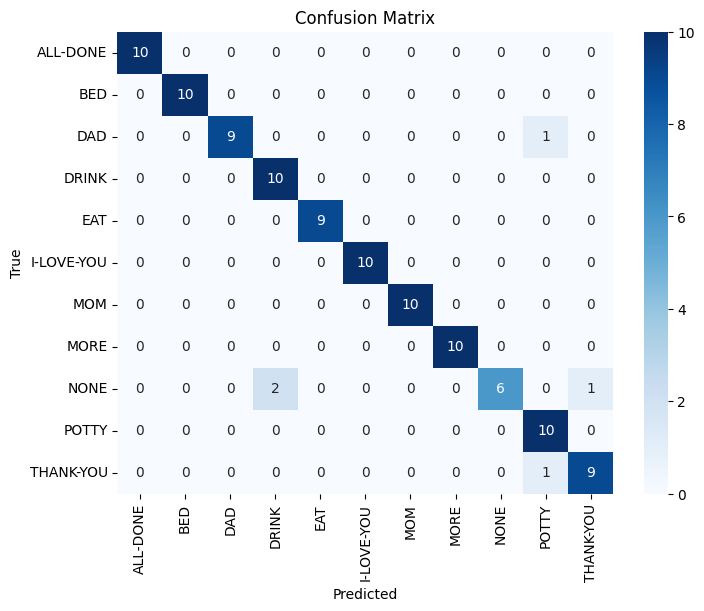

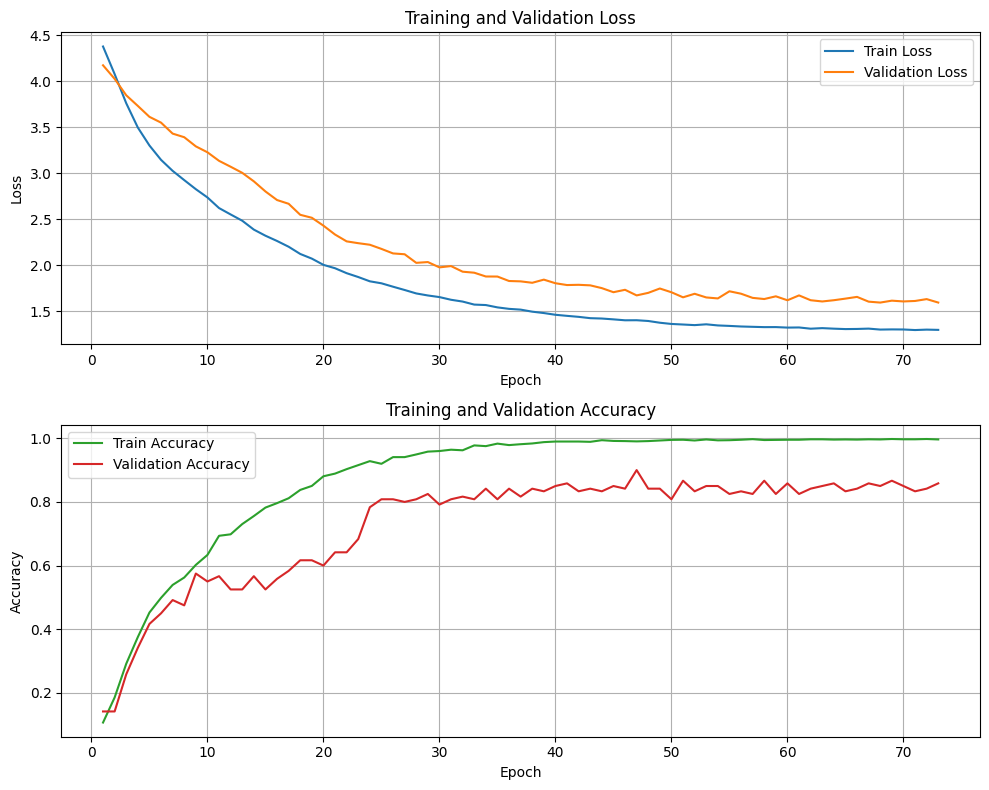

In [22]:
model_dev_v1 = Sequential([
    InputLayer(shape=(sequence_length, 2044)),
    
    # Conv1D(filters=390, kernel_size=5, activation="relu"),
    # MaxPooling1D(pool_size=3),
    # Dropout(0.1),
    # Conv1D(filters=128, kernel_size=3, activation="relu"),
    # MaxPooling1D(pool_size=3),
    # BatchNormalization(),
    
    # GRU(132, return_sequences=True), 
    # Dropout(0.4),
    # Bidirectional(GRU(96)), 
    # Dense(128, activation="relu"),
    # Dropout(0.5),
    # Dense(48, activation="relu"),
    # Dropout(0.5),
    # Activation("tanh"),
    # Dense(len(class_labels), activation='softmax', kernel_regularizer=L1L2(), bias_regularizer=L2(), activity_regularizer=L2())  # Output layer for classification

    # Conv1D(filters=384, kernel_size=3, activation='leaky_relu', kernel_regularizer=L1L2()),
    # BatchNormalization(),
    # MaxPooling1D(pool_size=2),
    
    # Dense(96, activation="relu6"),
    # BatchNormalization(),
    
    # Conv1D(filters=128, kernel_size=3, activation='tanh'),
    # MaxPooling1D(pool_size=2),
    
    # Conv1D(filters=64, kernel_size=3, activation='tanh'),
    # MaxPooling1D(pool_size=2),
    # BatchNormalization(),

    # Bidirectional(GRU(376, return_sequences=True, kernel_regularizer=L2(1.0848960662999816e-05))),
    # Dropout(0.354569645899713),
    
    # Bidirectional(GRU(267, return_sequences=True, dropout=0.12, recurrent_dropout=0.12)),

    # Bidirectional(GRU(352, return_sequences=True)),
    # LayerNormalization(),
    # Dropout(0.13),
    
    # GRU(120, kernel_regularizer=L2(6.142117138252424e-05)),
    # BatchNormalization(),
    # Activation('relu6'),
    
    # Dense(100, activation='tanh'),
    # Dropout(0.5),
    
    # Dense(len(class_labels), activation='softmax', kernel_regularizer=L1L2(0.0001, 0.0001), bias_regularizer=L2(0.00025))  # Output layer for classification

    Conv1D(filters=384, kernel_size=5, activation="leaky_relu", kernel_regularizer=L1L2(0.00001, 0.0001), bias_regularizer=L2(0.0001)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dense(units=96, activation="tanh"),
    Conv1D(filters=128, kernel_size=3),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3),
    MaxPooling1D(pool_size=3),
    BatchNormalization(),

    Bidirectional(LSTM(units=376, kernel_regularizer=L2(.0848960662999816e-05), return_sequences=True)),
    Dropout(0.354569645899713),
    Bidirectional(GRU(units=352, return_sequences=True)),
    GRU(units=120, kernel_regularizer=L2(6.142117138252424e-05)),
    LayerNormalization(),

    Activation(activation="tanh"),
    Dense(units=100, activation="tanh"),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax', kernel_regularizer=L1L2(0.01, 0.001), bias_regularizer=L2(0.0001))  # Output layer for classification

])
# from keras._tf_keras.keras.models import load_model
# model_dev_v1 = load_model(r"model_dev_v1_vr2.keras")

model_dev_v1.compile(optimizer=SGD(learning_rate=1.0e-3, weight_decay=1e-6, momentum=0.975, nesterov=True, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-12)	
history_dev_1 = model_dev_v1.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=100,  # Adjust epochs as needed
    batch_size=30,  # Adjust batch size as needed
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_accuracy = model_dev_v1.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

y_pred = model_dev_v1.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
create_graphs(history_dev_1, cm, class_labels)



In [17]:
model_dev_v1.to_json()

'{"module": "keras", "class_name": "Sequential", "config": {"name": "sequential_1", "trainable": true, "dtype": "float32", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 30, 2044], "dtype": "float32", "sparse": false, "name": "input_layer_1"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv1D", "config": {"name": "conv1d_3", "trainable": true, "dtype": "float32", "filters": 384, "kernel_size": [3], "strides": [1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1], "groups": 1, "activation": "leaky_relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": {"module": "keras.regularizers", "class_name": "L1L2", "config": {"l1": 0.0, "l2": 0.0}, "regist

In [6]:
model_dev_v1.save("model_dev_v1_vr2.keras")

In [7]:
model_dev_v1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 28, 384)        │     2,355,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 14, 384)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 384)        │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14, 96)         │        36,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 12, 128)        │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 4, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 2, 752)         │       997,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 752)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 2, 704)         │     2,335,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 120)            │       297,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 120)            │           240 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        12,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │         1,111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,197,688 (46.53 MB)

 Trainable params: 6,098,395 (23.26 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 6,098,397 (23.26 MB)